

<div>
<img align="left" src="caffe.jpeg" >
<img align="left" src="digit.png" >
</div>



# Begining in Deep Learning Framework: Caffe

- http://christopher5106.github.io/deep/learning/2015/09/04/Deep-learning-tutorial-on-Caffe-Technology.html
- https://github.com/NVIDIA/caffe
- https://github.com/BVLC/caffe/tree/master/docker
- http://caffe.berkeleyvision.org


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature
from skimage import data, color, exposure
import caffe

%matplotlib inline
print(caffe.__file__)


/opt/caffe/python/caffe/__init__.pyc


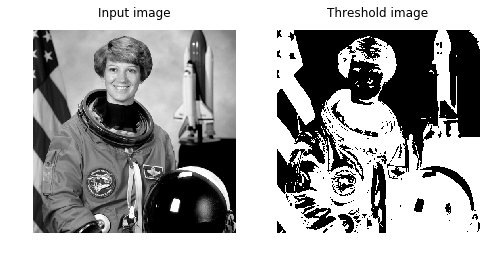

In [2]:
# original image
image = color.rgb2gray(data.astronaut())

# threshold image
mu = 0.5
imbw  = (image < mu);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(imbw, cmap=plt.cm.gray)
ax2.set_title('Threshold image')
ax1.set_adjustable('box-forced')
plt.show()



We do so by defining and then optimising the following objective function:
![](eq1.png)

In [3]:
# https://github.com/BVLC/caffe/wiki/Model-Zoo

from caffe import layers as L
from caffe import params as P

def create_arq():
   
    n = caffe.NetSpec()
    n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='pydatagenerate'), 
                               param_str='{"batch_size":1, "im_shape":50, "mu":0.5 }', ntop=2 )    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=1, stride=1, pad=1, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant',  value=0 ))  
    n.pool1 = L.Pooling(n.conv1, kernel_size=3, stride=1, pad=1, pool=P.Pooling.MAX)
    n.loss =  L.Python(n.pool1, n.label, python_param = dict(module = 'caffelayerpython', 
                        layer = 'pyimgloss'), ntop=1 )
    
    return 'name: "feactnet"\n' + str(n.to_proto())

with open('train.prototxt', 'w') as f:
    f.write(create_arq());

#print arq
print(create_arq())
{ 0

name: "feactnet"
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "label"
  python_param {
    module: "caffelayerpython"
    layer: "pydatagenerate"
    param_str: "{\"batch_size\":1, \"im_shape\":50, \"mu\":0.5 }"
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 1
    pad: 1
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.00999999977648
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 1
    pad: 1
  }
}
layer {
  name: "loss"
  type: "Python"
  bottom: "pool1"
  bottom: "label"
  top: "loss"
  python_param {
    module: "caffelayerpython"
    layer: "pyimgloss"
  }
}



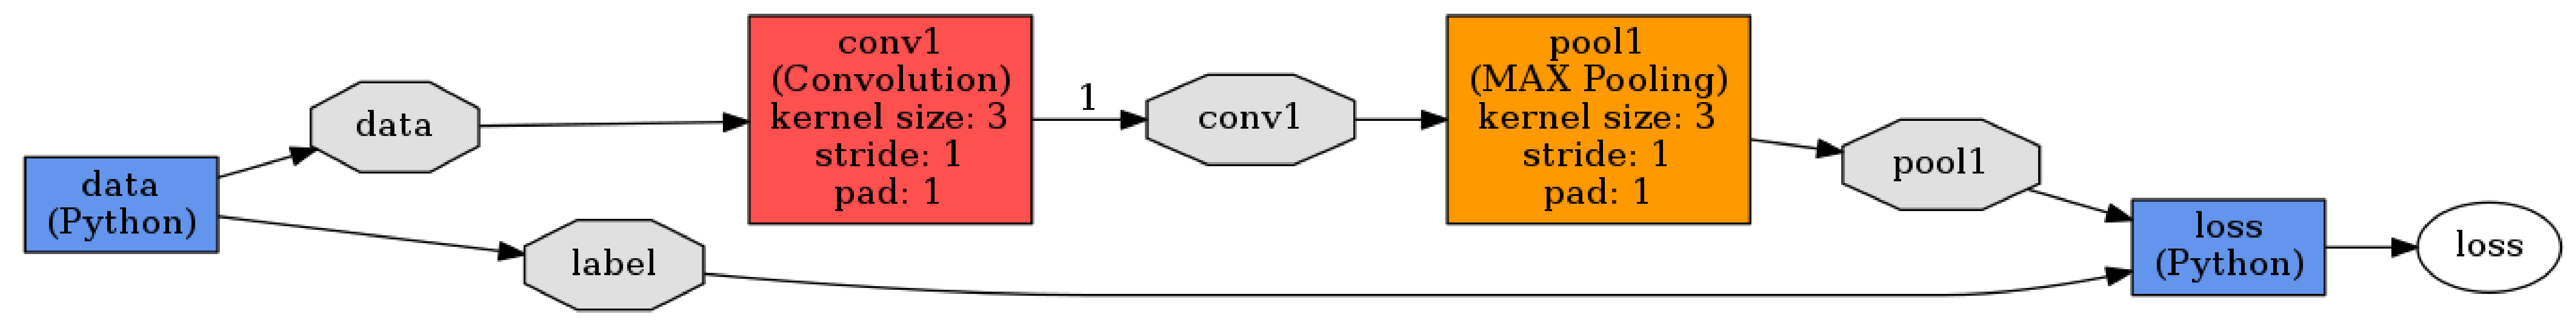

In [14]:
#import os
#os.system( 'python /opt/caffe/python/draw_net.py train.prototxt my_net.png' )
#open my_net.png

#prerequisitos
#pip install pydotplus
#apt-get update
#apt-get install graphviz

from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2

nnet = caffe_pb2.NetParameter();
text_format.Merge(open('train.prototxt').read(), nnet);
caffe.draw.draw_net_to_file(nnet, 'my_net.png', 'LR');

image_net = Image.open('my_net.png');
image_net.load();

fig = plt.figure(figsize=(100, 100))
plt.imshow(image_net);
plt.axis('off')
plt.show();

In [4]:
# https://github.com/BVLC/caffe/wiki/Solver-Prototxt

solvername = 'solver.prototxt';
train_prototxt_path = 'train.prototxt';
working_directory   = 'snapshot';

# solver
solver = {   
    'net': train_prototxt_path,
    'base_lr': 0.01,
    'lr_policy': 'inv',
    'gamma': 0.01,
    'power': 0.75,
    'display': 50,
    'max_iter': 1000,
    'momentum': 0.95,
    'weight_decay': 0.0005,
    'snapshot': 100, # only at the end
    'snapshot_prefix': working_directory + '/snapshot',
    'solver_mode': 'CPU'
    };

# save
with open(solvername, 'w') as f:
    for key in solver.keys():
        value = solver[key];
        if type(value) is str and key != 'solver_mode':
            f.write('{} : "{}"\n'.format(key, value))
            print('{} : "{}"'.format(key, value))
        else: 
            f.write('{} : {}\n'.format(key, value))
            print('{} : {}'.format(key, value))


power : 0.75
max_iter : 1000
base_lr : 0.01
weight_decay : 0.0005
lr_policy : "inv"
snapshot_prefix : "snapshot/snapshot"
snapshot : 100
gamma : 0.01
solver_mode : CPU
net : "train.prototxt"
display : 50
momentum : 0.95


In [5]:
# CPU
caffe.set_mode_cpu()
# GPU
#caffe.set_device(0)
#caffe.set_mode_gpu()

In [6]:
# load net
net = caffe.Net(train_prototxt_path, caffe.TRAIN)

In [7]:
# forward
out = net.forward();
print(out['loss'])

[ 1.51377964]


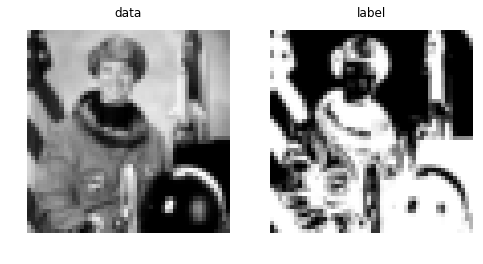

[('data', (1, 1, 50, 50)),
 ('label', (1, 1, 50, 50)),
 ('conv1', (1, 1, 50, 50)),
 ('pool1', (1, 1, 50, 50)),
 ('loss', (1,))]

In [8]:
# net.blobs
# net.blobs['data'] 
# net.blobs['conv']

ldata  = net.blobs['data'].data[...];
llabel = net.blobs['label'].data[...];

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(ldata[0,0,:,:], cmap=plt.cm.gray)
ax1.set_title('data')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(llabel[0,0,:,:], cmap=plt.cm.gray)
ax2.set_title('label')
ax1.set_adjustable('box-forced')
plt.show()

[(k, v.data.shape) for k, v in net.blobs.items()]


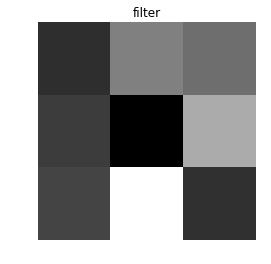

[[-0.00609999  0.0047077   0.00231602]
 [-0.0042342  -0.01236331  0.0105055 ]
 [-0.00329309  0.02176828 -0.0058503 ]]


[('conv1', (1, 1, 3, 3), (1,))]

In [9]:
# net.params
# net.params['conv'][0]
# net.params['conv'][1] #bias

filters = net.params['conv1'][0].data[...];
plt.imshow(filters[0,0,:,:], cmap=plt.cm.gray);
plt.title('filter');
plt.axis('off');
plt.show();

print(filters[0,0,:,:])

[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]



In [10]:
solver = None;
solver = caffe.SGDSolver('solver.prototxt');

#preinitialization
#solver.net.copy_from('model.caffemodel');

In [11]:
#Training 

#solver.net.forward()  # train net
#solver.test_nets[0].forward()  # test net (there can be more than one)
#solver.net.backward()
#solver.step(1)
#solver.solve()

solver.step(1)
train_loss = solver.net.blobs['loss'].data
print(train_loss)


[ 4.22621202]


step: 0 loss 4.12275
step: 1 loss 4.08269
step: 2 loss 4.05565
step: 3 loss 4.03475
step: 4 loss 4.01752
step: 5 loss 4.00275
step: 6 loss 3.98976
step: 7 loss 3.97814
step: 8 loss 3.96758
step: 9 loss 3.95790
step: 10 loss 3.94894
step: 11 loss 3.94058
step: 12 loss 3.93277
step: 13 loss 3.92542
step: 14 loss 3.91843
step: 15 loss 3.91184
step: 16 loss 3.90554
step: 17 loss 3.89951
step: 18 loss 3.89376
step: 19 loss 3.88827
step: 20 loss 3.88293
step: 21 loss 3.87782
step: 22 loss 3.87289
step: 23 loss 3.86811
step: 24 loss 3.86346
step: 25 loss 3.85905
step: 26 loss 3.85465
step: 27 loss 3.85049
step: 28 loss 3.84638
step: 29 loss 3.84236
step: 30 loss 3.83855
step: 31 loss 3.83465
step: 32 loss 3.83104
step: 33 loss 3.82745
step: 34 loss 3.82385
step: 35 loss 3.82038
step: 36 loss 3.81707
step: 37 loss 3.81384
step: 38 loss 3.81044
step: 39 loss 3.80731
step: 40 loss 3.80430
step: 41 loss 3.80126
step: 42 loss 3.79820
step: 43 loss 3.79526
step: 44 loss 3.79240
step: 45 loss 3.7896

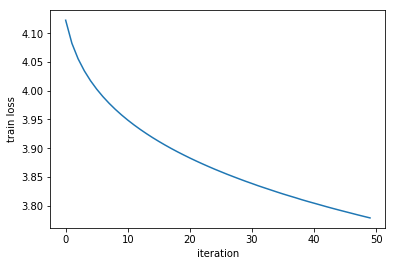

CPU times: user 20min 51s, sys: 25.5 s, total: 21min 16s
Wall time: 21min 28s


In [12]:
%%time
niter = 50
test_interval = 1
# losses will also be stored in the log
train_loss = np.zeros(niter)

# the main solver loop
for it in range(niter):
    
    solver.step(1000)  # SGD by Caffe    
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    print('step: {} loss {:0.5f}'.format(it,train_loss[it]))
    
    
plt.figure()
plt.plot(np.arange(niter), train_loss)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.show()


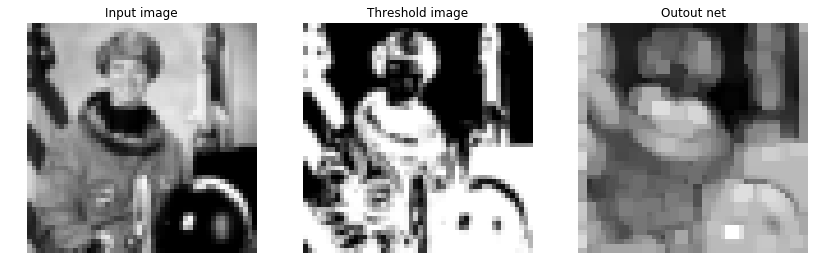

In [16]:
import scipy.misc

# test
# original image
net = caffe.Net('test.prototxt', 'model/snapshot_iter_50000.caffemodel', caffe.TEST);

# image input
image = color.rgb2gray(data.astronaut());

# gt
mu = 0.5;
label  = (image < mu);


image = scipy.misc.imresize(image,(50,50))
label = scipy.misc.imresize(label,(50,50))

im_input = image[np.newaxis, np.newaxis, :, :];
net.blobs['data'].reshape(*im_input.shape);
net.blobs['data'].data[...] = im_input;
out = net.forward();
imout = out['pool1'];


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(label, cmap=plt.cm.gray)
ax2.set_title('Threshold image')
ax2.set_adjustable('box-forced')

ax3.axis('off')
ax3.imshow(imout[0,0,:,:], cmap=plt.cm.gray)
ax3.set_title('Outout net')
ax3.set_adjustable('box-forced')

plt.show()



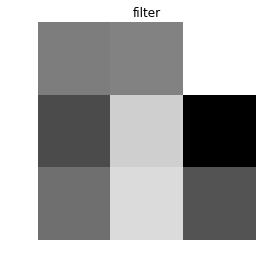

[[-0.00383924 -0.0032714   0.01310666]
 [-0.01037045  0.00685909 -0.02020129]
 [-0.00564338  0.00837543 -0.00939668]]


In [19]:
filters = net.params['conv1'][0].data;
filters = filters[0,0,:,:];
plt.imshow(filters, cmap=plt.cm.gray);
plt.title('filter');
plt.axis('off');
plt.show();

print(filters)


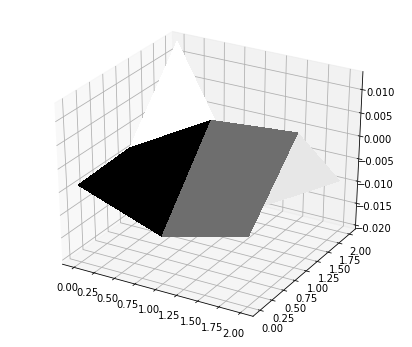

In [18]:
from mpl_toolkits.mplot3d import Axes3D
# generate some sample data
import scipy.misc


# downscaling has a "smoothing" effect
#lena = scipy.misc.imresize(lena, 0.15, interp='cubic')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:filters.shape[0], 0:filters.shape[1]]

# create the figure
fig = plt.figure( figsize=(7,6) )
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, filters ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0, antialiased=False)

# show it
plt.show()
